# Notebook de Exemplos: Interpolação de Pontos na Reta Real

Este notebook demonstra o uso das seguintes funções de interpolação:

1.  `lin_interp`: Realiza a interpolação linear por partes entre os pontos.

2.  `poly_interp`: Calcula o polinômio interpolador (Interpolação Polinomial).

3.  `hermite_interp`: Calcula o polinômio interpolador de Hermite (usando valores e derivadas).

Todas as funções também demonstram a representação gráfica dos pontos e do polinômio/função interpoladora.

# Código - Interpolação Linear

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from typing import Callable

def _ordenar_coordenadas(x: list, y: list) -> list:
    """Ordena as coordenadas mantendo 'pareamento'.
    
    Pega as coordenadas x e y de cada ponto, ordena em ordem crescente
    as coordenadas x e mantém pareamento com y. Função privada, auxiliar
    da função principal lin_interp.

    Args:
        x: lista das coordenadas x, em x[i], de cada ponto i.
        y: lista das coordenadas y, em y[i], de cada ponto i.

    Returns:
        x_ord: lista das coordenadas x em ordem crescente.
        y_ord: lista das coordenadas y, pareadas com as coordenadas x.
    """
    x_np = np.array(x)
    y_np = np.array(y)

    idx = np.argsort(x_np)

    x_ord = x_np[idx]
    y_ord = y_np[idx]

    return x_ord, y_ord

def _plotar(x: list,
            y: list,
            f: Callable,
            titulo: str = 'Gráfico'):
    """Plotagem de pontos e de uma função.

    Plotagem dos pontos indicados pelas coordenadas x e y, seguindo a
    função f. Função privada, auxiliar da função principal lin_interp.

    Args:
        x: lista das coordenadas x, em x[i], de cada ponto i.
        y: lista das coordenadas y, em y[i], de cada ponto i.
        f: função que será plotada.

    Returns:
        None
    """
    x_points = np.linspace(x[0], x[-1], 500)
    y_points = [f(xp) for xp in x_points]

    _, ax = plt.subplots()
    ax.scatter(x, y, color = 'red', label = 'Dados')
    ax.plot(x_points, y_points, label = 'Interpolação Linear por Partes')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(titulo)
    ax.grid(True)
    plt.show()

    return

def lin_interp(x: list,
               y: list,
               plot: bool = False
               ) -> Callable:
    """Interpolação linear por partes a partir dos pontos dados.

    Essa função ordena pontos a partir da ordem crescente das
    coordenadas x. Em seguida, cria retas descritas pela nova
    função f, que 'ligam' os pontos descritos pelas coordenadas x e y.
    É permitida extrapolação. Por fim, caso 'plot = True', há uma
    plotagem do gráfico correspondente.

    Args:
        x: lista das coordenadas x, em x[i], de cada ponto i.
        y: lista das coordenadas y, em y[i], de cada ponto i.
        plot: indica se deve haver a plotagem (True) ou não (False).

    Returns:
        f: função de interpolação linear por partes
    """

    # Ordenação das coordenadas x em ordem crescente
    x, y = _ordenar_coordenadas(x, y)

    # Definição da função de interpolação
    def f(x1: float) -> float:
        if x1 < x[0]: # Caso fora do intervalo, continua a reta mais próxima
            a = (y[1] - y[0])/(x[1] - x[0])
            b = y[0]
                    
            y1 = b + (x1 - x[0]) * a 
            return y1
        elif x1 > x[-1]: # Caso fora do intervalo, continua a reta mais próxima
            a = (y[-1] - y[-2])/(x[-1] - x[-2])
            b = y[-2]
                    
            y1 = b + (x1 - x[-2]) * a
            return y1
        else:
            for i in range (1, len(x)): # Busca intervalo do número x1 para atribuir valor f(x1)
                if x[i] >= x1 >= x[i-1]:
                    a = (y[i] - y[i-1])/(x[i] - x[i-1])
                    b = y[i-1]
                    
                    y1 = b + (x1 - x[i-1]) * a # Aproximação linear
                    
                    return y1

    # Plotagem do gráfico correspondente à função f
    if plot:
        _plotar(x, y, f, 'Interpolação Linear por Partes')

    return f

Exemplo 1

Segue abaixo as coordenadas x e y dos pontos do exemplo 1
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[34, 12, 60, 35, 7, 23, 6, 50, 10, 4, 21]


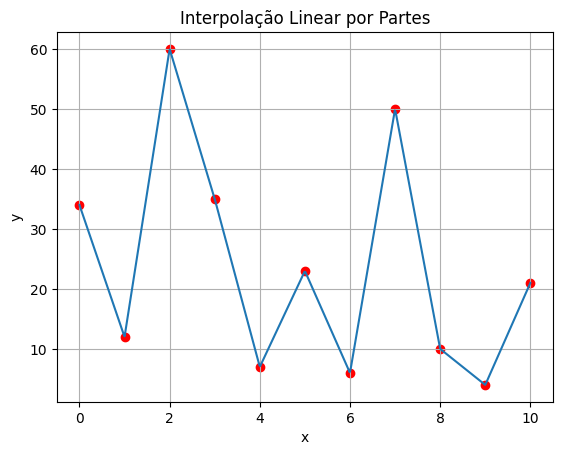

O valor interpolado em 1.5 é p(num)=36.0
O valor interpolado em 2.8 é p(num)=40.0
O valor interpolado em 3.9 é p(num)=9.8
O valor interpolado em 5.7 é p(num)=11.1
O valor interpolado em 9.1 é p(num)=5.7
O valor interpolado em 11.1 é p(num)=39.7
O valor interpolado em 15 é p(num)=106.0

Note que extrapolação é permitida

--------------

Exemplo 2

Perceba que, mesmo ao mudar a ordem das coordenadas, o gráfico continua o mesmo

Segue abaixo as coordenadas x e y dos pontos do exemplo 2
[0, 1, 10, 2, 4, 7, 5, 6, 8, 9, 3]
[34, 12, 21, 60, 7, 50, 23, 6, 10, 4, 35]


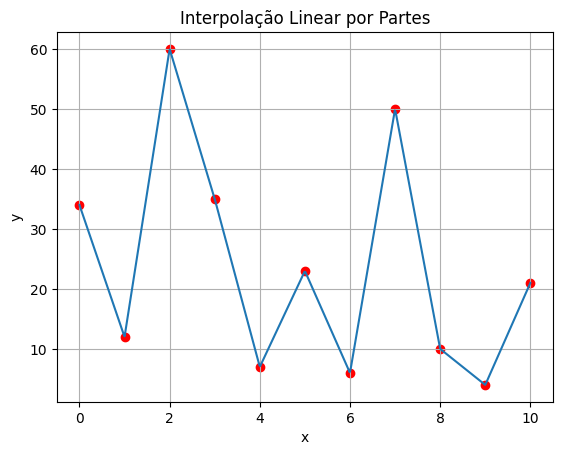

In [2]:
print('Exemplo 1')

x = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
y = [34, 12, 60, 35, 7, 23, 6, 50, 10, 4, 21]

print('\nSegue abaixo as coordenadas x e y dos pontos do exemplo 1')
print(x)
print(y)

p = lin_interp(x, y, plot = True)

teste = [1.5, 2.8, 3.9, 5.7, 9.1, 11.1, 15]
if p:
    for num in teste:
        print(f'O valor interpolado em {num} é p(num)={round(p(num),2)}')

print('\nNote que extrapolação é permitida')

print('\n--------------\n')
print('Exemplo 2')
print('\nPerceba que, mesmo ao mudar a ordem das coordenadas, o gráfico continua o mesmo')
x1 = [0, 1, 10, 2, 4, 7, 5, 6, 8, 9, 3]
y1 = [34, 12, 21, 60, 7, 50, 23, 6, 10, 4, 35]
print('\nSegue abaixo as coordenadas x e y dos pontos do exemplo 2')
print(x1)
print(y1)

f = lin_interp(x1,y1, plot = True)

# Código - Interpolação Polinomial

In [33]:
def _poly_interp_plotter(x_val: list,
                         y_val: list,
                         P: Callable,
                         res: int,
                         pcolor: str,
                         ccolor: str,
                         titulo: str) -> None:
    """
    Plotar gráfico da interpolação polinomial.

    Parameters
    ----------
        x_val : list
            lista das coordenadas x.
        y_val : list
            lista das coordenadas y.
        P : Callable
            função que corresponde ao polinômio interpolador.
        res : int = 100, optional
            número de pontos para a plotagem do polinômio.
        pcolor : str = "#234883", optional
            cor dos pontos originais.
        ccolor : str = "#4287f5", optional
            cor do polinômio.

    Returns
    -------
        None
    """

    # pontos recebidos
    plt.scatter(x_val, y_val, color=pcolor, label='Pontos Originais', zorder=5)

    # gerando e plotando os pontos do polinômio
    x_plot = np.linspace(min(x_val), max(x_val), res)
    y_plot = [P(x) for x in x_plot]
    plt.plot(x_plot, y_plot, color=ccolor, label='Interpolação Polinomial', linewidth=2)

    plt.title(titulo)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.grid(True)
    plt.show()

    return


In [19]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable


def poly_interp(x_val: list,
                y_val: list,
                plot: bool = False,
                res: int = 100,
                pcolor: str = "#234883",
                ccolor: str = "#4287f5",
                titulo: str = "Interpolação Polinomial de Lagrange") -> Callable:
    """
    Gera um polinômio interpolador usando o método de Lagrange.

    Esta função recebe um conjunto de pontos (x, y) e retorna uma 
    função (polinômio) que passa exatamente por todos esses pontos.

    Parameters
    ----------
    x_val : list
        Uma lista de coordenadas x dos pontos. Os valores devem ser
        todos distintos entre si.
    y_val : list
        Uma lista de coordenadas y dos pontos. Deve ter o mesmo
        tamanho de `x_val`.
    plot : bool, optional
        Se True, exibe um gráfico do polinômio e dos pontos 
        originais. O padrão é False.
    res : int, optional
        Resolução (número de pontos) usada para desenhar a 
        curva do polinômio no gráfico. O padrão é 100.
    pcolor : str, optional
        Cor dos pontos originais no gráfico. O padrão é "#234883".
    ccolor : str, optional
        Cor da curva do polinômio no gráfico. O padrão é "#4287f5".
    titulo : str, optional
        Título do gráfico. O padrão é "Interpolação Polinomial de Lagrange".

    Returns
    -------
    Callable
        Uma função P(x) que recebe um número (int ou float) e 
        retorna o valor do polinômio interpolador avaliado 
        naquele ponto x.

    Raises
    ------
    ValueError
        - Se `x_val` e `y_val` tiverem tamanhos diferentes.
        - Se as listas de entrada estiverem vazias.
        - Se `x_val` contiver valores duplicados.
        - Se `res` não for um inteiro.
        - Se `pcolor` ou `ccolor` não forem strings.
        - Se `titulo` não for uma string.

    Examples
    --------
    >>> x = [0, 1, 2]
    >>> y = [1, 3, 2]
    >>> pol = poly_interp(x, y)
    >>> print(pol(1.5))
    2.625
    """

    # tratamento de erros
    n = len(x_val)
    m = len(y_val)

    if n != m:
        raise ValueError("As listas de coordenadas x e y devem ter o mesmo tamanho.")

    if n == 0:
        raise ValueError("Lista de pontos x inserida está vazia.")
    elif m == 0:
        raise ValueError("Lista de pontos y inserida está vazia.")
    
    if len(set(x_val)) != n:
        raise ValueError("As coordenadas x devem ser todas distintas.")
    
    if not (type(res) == int):
        raise ValueError("O argumento res deve ser um inteiro.")
    
    if not (type(pcolor) == str):
        raise ValueError("O argumento pcolor deve ser uma string.")
    
    if not (type(ccolor) == str):
        raise ValueError("O argumento ccolor deve ser uma string.")
    
    if not (type(titulo) == str):
        raise ValueError("O argumento titulo deve ser uma string.")
    

    
    # convertendo as arrays para o tipo do numpy
    x_val_np = np.array(x_val)
    y_val_np = np.array(y_val)


    def P(x: int | float) -> int | float:
        """
        Função que calcula o valor do polinômio interpolador em x.

        Parameters
        ----------
        x : int | float
            Ponto onde o polinômio será avaliado.

        Returns
        -------
        int | float
            O valor do polinômio interpolador em x.

        Raises
        ------
        ValueError
            Se x não for um número (int ou float).
        """

        if not np.isreal(x):
            raise ValueError("O argumento x deve ser um número real.")

        # acumula o termo y_j * L_j(x)
        acc_som = 0

        # loop do somatório
        for j in range(n):          
            # o produtorio exije que j != i
            x_val_sj = np.delete(x_val_np, j)

            # calculando numeradores e denominadores do produtorio
            num = x - x_val_sj
            den = x_val_np[j] - x_val_sj

            acc_som += y_val_np[j] * np.prod(num / den)
        
        return acc_som
    
    # plotagem do grafico caso o usuario deseje
    if plot:
        _poly_interp_plotter(x_val, y_val, P, res, pcolor, ccolor, titulo)

    return P

Exemplo 1
Pontos: [(0, 0), (1, 3), (3, -2), (4, 0)]


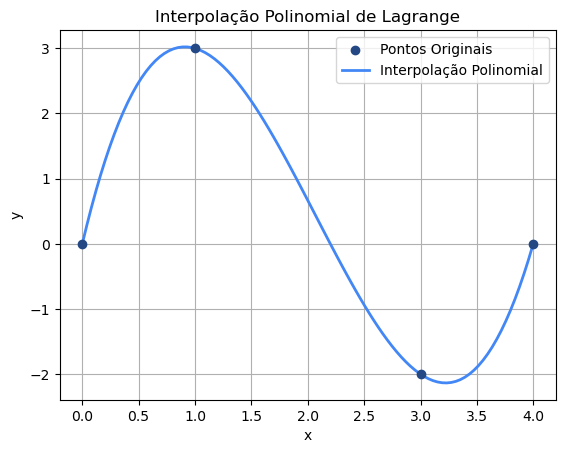

O valor interpolado em x = 10 é P(x) = 390.00
O valor interpolado em x = 13.98 é P(x) = 1369.63
O valor interpolado em x = 26.384 é P(x) = 11902.14
O valor interpolado em x = 49 é P(x) = 85995.00

----------------------------------------

Exemplo 2


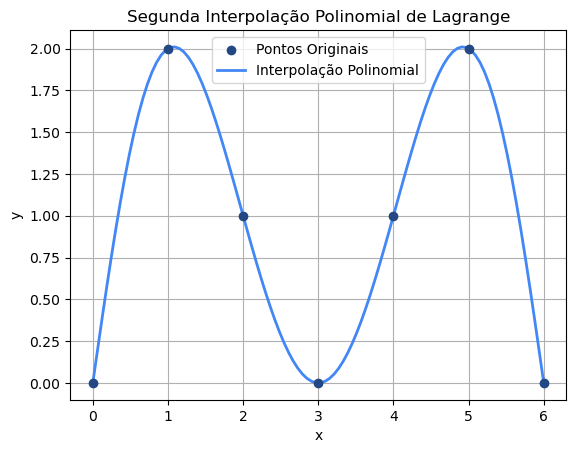

O valor interpolado em x = 10 é P(x) = 539.00
O valor interpolado em x = 13.98 é P(x) = 11719.27
O valor interpolado em x = 26.384 é P(x) = 1300848.42
O valor interpolado em x = 49 é P(x) = 78022210.00


In [34]:
# testes

print("Exemplo 1")

x = [0, 1, 3, 4]
y = [0, 3, -2, 0]

print(f"Pontos: {[(x_val, y_val) for x_val, y_val in zip(x, y)]}")

p = poly_interp(x, y, plot=True)

pontos_exemplo1 = [10, 13.98, 26.384, 49]

for num in pontos_exemplo1:
    print(f"O valor interpolado em x = {num} é P(x) = {p(num):.2f}")

print('\n', '-'*40, '\n', sep='')
print("Exemplo 2")

x = [0, 1, 2, 3, 4, 5, 6]
y = [0, 2, 1, 0, 1, 2, 0]

p = poly_interp(x, y, plot=True, titulo="Segunda Interpolação Polinomial de Lagrange")

pontos_exemplo2 = [29.643, 18.57, 47.15, 93.6, 45.3, 25.332, 2.1]

for num in pontos_exemplo1:
    print(f"O valor interpolado em x = {num} é P(x) = {p(num):.2f}")



# Código - Hermite

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from typing import Callable

def _hermite_interp_mat(x_pontos: list, y_pontos: list, dy_pontos: list) -> Callable | None:
    """
    Função interna - Cria a função matemática da interpolação.
    
    Essa função apenas resolve o sistema linear e 
    retorna a função polinomial (Callable) que pode ser usada 
    para calcular valores.

    Parâmetros:
        x_pontos: Coordenadas x (n valores).
        y_pontos: Coordenadas y (n valores).
        dy_pontos: Derivadas dy/dx em cada x (n valores).

    Retorna:
        Uma função (Callable) que avalia o polinômio, ou None se der erro.
    """
    try:
        x_pts = np.asarray(x_pontos, dtype=float)
        y_pts = np.asarray(y_pontos, dtype=float)
        dy_pts = np.asarray(dy_pontos, dtype=float)
    except Exception as e:
        print(f"Erro ao converter entradas para arrays numpy: {e}")
        return None

    n = len(x_pts)
    if n == 0:
        print("Erro: As listas de pontos não podem estar vazias.")
        return None
    if len(y_pts) != n or len(dy_pts) != n:
        print("Erro: As listas x, y, e dy devem ter o mesmo tamanho.")
        return None
        
    num_coefs = 2 * n
    
    #valores min/max não são necessários para checagem, mas podem ser úteis se quiser saber o intervalo
    x_min = np.min(x_pts)
    x_max = np.max(x_pts)
    
    A = np.zeros((num_coefs, num_coefs))
    b = np.zeros(num_coefs)
    
    for i in range(n):
        x = x_pts[i]
        
        A[2*i] = [x**j for j in range(num_coefs)]
        b[2*i] = y_pts[i]
        
        linha_dy = [0.0] + [j * x**(j-1) for j in range(1, num_coefs)]
        A[2*i + 1] = linha_dy
        b[2*i + 1] = dy_pts[i]
    
    try:
        coefs = np.linalg.solve(A, b)
    except np.linalg.LinAlgError:
        print("Erro: Matriz singular. Verifique se há pontos x duplicados.")
        return None

    def polinomio_interpolador_hermite(x_novo: float | np.ndarray) -> float | np.ndarray:
        """
        Avalia o polinômio P(x_novo) = sum(c_j * x_novo^j)
        """
        x_val = np.asarray(x_novo, dtype=float)
        
        return np.polyval(coefs[::-1], x_val)
    
    return polinomio_interpolador_hermite

def _ordenar_coordenadas_hermite(x: list, y: list, dy: list) -> tuple:
    """
    Função interna - Ordena as coordenadas mantendo 'pareamento' para Hermite.

    Parâmetros:
    x: lista das coordenadas x, em x[i], de cada ponto i.
    y: lista das coordenadas y, em y[i], de cada ponto i.
    dy: lista das derivadas dy[i] em cada ponto i.

    Retorna:
    x_ord: lista das coordenadas x em ordem crescente.
    y_ord: lista das coordenadas y, pareadas com as coordenadas x.
    dy_ord: lista das derivadas, pareadas com as coordenadas x.
    """
    x_np = np.array(x)
    y_np = np.array(y)
    dy_np = np.array(dy)

    idx = np.argsort(x_np)

    x_ord = x_np[idx]
    y_ord = y_np[idx]
    dy_ord = dy_np[idx]

    return x_ord, y_ord, dy_ord

def _plotar_hermite(x: list, y: list, dy: list, f: Callable, titulo: str = "Interpolação de Hermite"):
    """
    Função interna - Plotagem de pontos, derivadas e da função de interpolação.

    Parâmetros:
    x: lista das coordenadas x, em x[i], de cada ponto i.
    y: lista das coordenadas y, em y[i], de cada ponto i.
    dy: lista das derivadas dy[i] em cada ponto i.
    f: função de interpolação que será plotada.
    titulo: título do gráfico.

    Retorna:
    None
    """
    #criar pontos para a curva suave
    x_min, x_max = min(x), max(x)
    
    #estende ligeiramente o plot para mostrar a extrapolação, se desejado
    #você pode ajustar 'padding' ou remover se preferir plotar só o intervalo
    padding = 0.1 * (x_max - x_min)
    if padding == 0: #caso de ponto único
        padding = 1.0
        
    x_curve = np.linspace(x_min - padding, x_max + padding, 500)
    y_curve = f(x_curve)
    
    #calcular as retas tangentes nos pontos de interpolação
    comprimento_tangente = 0.1 * (x_max - x_min) if (x_max - x_min) > 0 else 0.1
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    #gráfico principal
    ax.scatter(x, y, color='red', s=50, zorder=5, label='Pontos de dados')
    ax.plot(x_curve, y_curve, 'b-', linewidth=2, label='Polinômio de Hermite')
    
    #adc retas tangentes
    tangente_plotted = False
    for xi, yi, dyi in zip(x, y, dy):
        x_tang = [xi - comprimento_tangente, xi + comprimento_tangente]
        y_tang = [yi - comprimento_tangente * dyi, yi + comprimento_tangente * dyi]
        label = 'Tangente' if not tangente_plotted else ""
        ax.plot(x_tang, y_tang, 'g--', alpha=0.7, linewidth=1, label=label)
        if not tangente_plotted:
            tangente_plotted = True
        ax.plot(xi, yi, 'ro', markersize=8)
    
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(titulo)
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    plt.tight_layout()
    plt.show()

def hermite_interp(x_pontos: list, y_pontos: list, dy_pontos: list, 
                   titulo: str = "Interpolação de Hermite") -> Callable:
    """
    Cria e plota uma função de interpolação polinomial de Hermite.

    Parâmetros:
        x_pontos: Coordenadas x (n valores).
        y_pontos: Coordenadas y (n valores).
        dy_pontos: Derivadas dy/dx em cada x (n valores).
        titulo: Título para o gráfico.

    Retorna:
        Função de interpolação de Hermite.

    Notas:
        Sobre a Extrapolação:
        Esta função sempre permite a extrapolação (avaliar valores de x 
        fora do intervalo de dados [min(x_pontos), max(x_pontos)]). 
        O usuário é responsável por verificar os resultados, pois 
        polinômios podem crescer rapidamente e produzir valores
        imprevisíveis fora do intervalo de interpolação.
    """
    #ordenar coordenadas
    x_ord, y_ord, dy_ord = _ordenar_coordenadas_hermite(x_pontos, y_pontos, dy_pontos)
    
    #criar função de interpolação
    f_interp = _hermite_interp_mat(x_ord, y_ord, dy_ord)
    
    if f_interp is None:
        print("Erro: Não foi possível criar a função de interpolação.")
        return None
    
    #plot
    # A função de plot também vai mostrar um pouco da extrapolação
    _plotar_hermite(x_ord, y_ord, dy_ord, f_interp, titulo)

    #a lógica de restrição foi removida.
    
    return f_interp

Exemplo 1


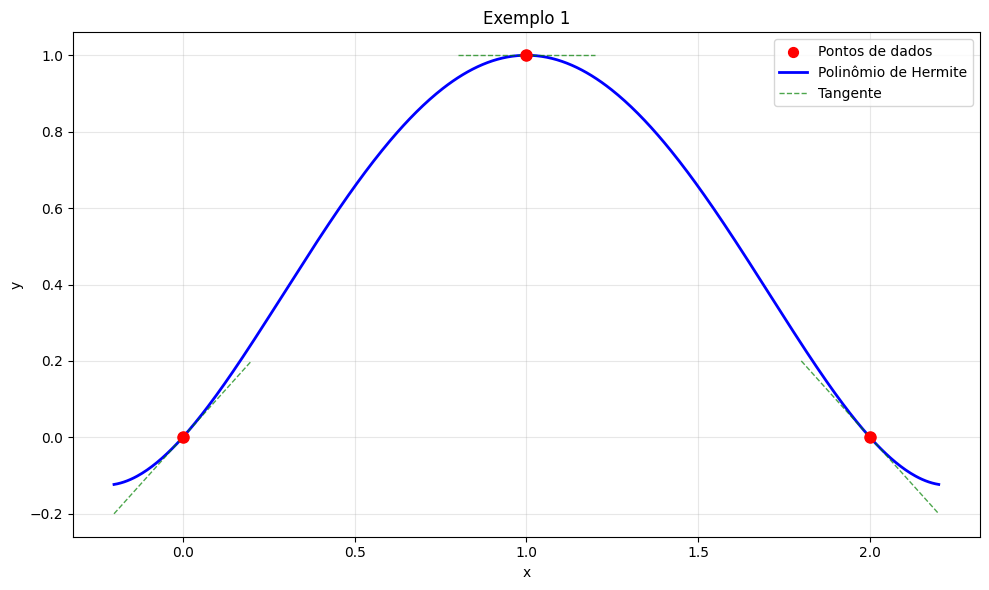

O valor interpolado em x=0.5 é: 0.6562
O valor interpolado em x=1.5 é: 0.6562


Exemplo 2


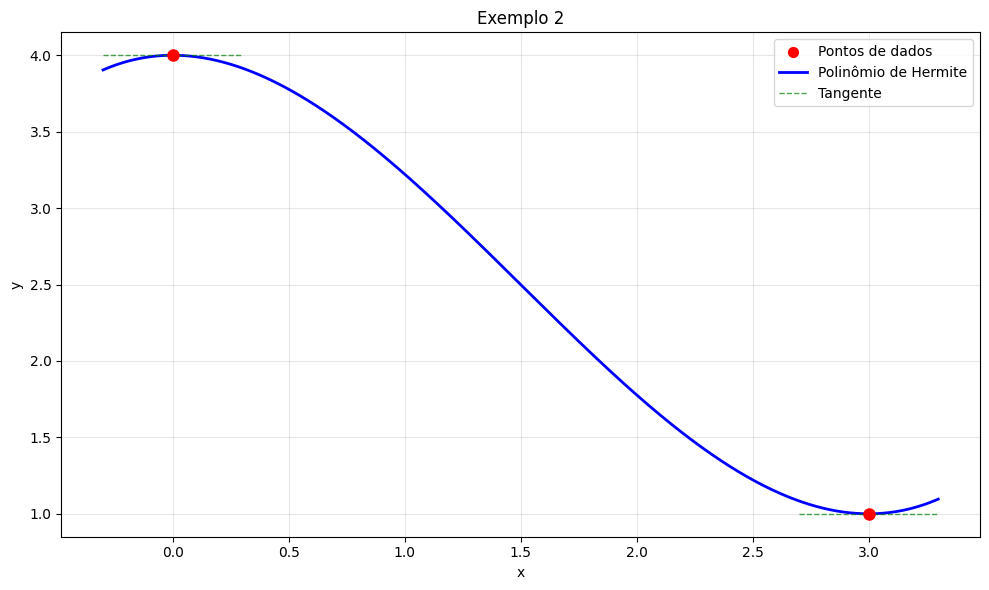

O valor interpolado em x=1.5 é: 2.5000


In [4]:
print("Exemplo 1")

x1 = [0, 1, 2]
y1 = [0, 1, 0]
dy1 = [1, 0, -1] 

p1 = hermite_interp(x1, y1, dy1, titulo="Exemplo 1")

if p1:
    print(f"O valor interpolado em x=0.5 é: {p1(0.5):.4f}")
    print(f"O valor interpolado em x=1.5 é: {p1(1.5):.4f}")
    
print("\n")
print("Exemplo 2")

x2 = [3, 0]
y2 = [1, 4]
dy2 = [0, 0] 

p2 = hermite_interp(x2, y2, dy2, titulo="Exemplo 2")

if p2:
    print(f"O valor interpolado em x=1.5 é: {p2(1.5):.4f}")